## Markdown file to be removed later, for now this is to track the progress of our report.
### Putting all the code, in we will put the written stuff later
### I've also not added the descriptions underneath the graphs, because I wasn't sure if we wanted to change them or not, we can always copy and paste from the project_proposal.ipynb file

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(dbplyr)
library(ggplot2)
install.packages("themis")
library(themis)
options(repr.matrix.max.rows = 6)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

In [2]:
#setting a fixed seed value (to be maintainied consistently throughout the entire project)
set.seed(50)


# Loading the dataset and ensuring that it is cleaned and wrangled
url <- "https://raw.githubusercontent.com/szulkifl/dsci-data-analysis-project-44/main/processed.hungarian.data.txt"
hungarian_data <- read_csv(url, col_names= c("age", "sex", "cp", "trestbps", 
                                             "chol", "fbs", "restecg", "thalac", "exang", "oldpeak", 
                                             "slope", "ca", "thal", "num" ),
                          show_col_types = FALSE) |>
                                             mutate(across(where(is.character), ~na_if(.x, "?"))) |> 
                                             mutate(trestbps = as.numeric(trestbps), 
                                                    chol = as.numeric(chol), 
                                                    restecg = as.numeric(restecg),
                                                    thalac = as.numeric(thalac),
                                                    num = as.character(num),
                                                    sex = as.character(sex)) |>
                                             mutate(num = fct_recode(num, "Negative" = "0", "Positive" = "1")) |>
                                             mutate(sex = recode(sex, "1" = "Male", "0" = "Female")) |>
                                             mutate(exang = recode(exang, "0" = "No", "1" = "Yes")) |>
                                             mutate (cp = recode( cp, "1" = "typical angina" , "2" = "atypical angina", 
                                                                "3" = "non-anginal pain", "4" = "asymptomatic" )) |>
                                             mutate (fbs = recode( fbs, "1" = "high fbs", "0" = "normal fbs")) |>
                  
                                             mutate(restecg = recode (restecg, "0" = "normal" , "1" = "abnormality", "2" = "hypertrophy"))

hungarian_data

age,sex,cp,trestbps,chol,fbs,restecg,thalac,exang,oldpeak,slope,ca,thal,num
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<fct>
28,Male,atypical angina,130,132,normal fbs,hypertrophy,185,No,0,NA,NA,NA,Negative
29,Male,atypical angina,120,243,normal fbs,normal,160,No,0,NA,NA,NA,Negative
29,Male,atypical angina,140,NA,normal fbs,normal,170,No,0,NA,NA,NA,Negative
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
56,Male,asymptomatic,155,342,high fbs,normal,150,Yes,3,2,NA,NA,Positive
58,Female,atypical angina,180,393,normal fbs,normal,110,Yes,1,2,NA,7,Positive
65,Male,asymptomatic,130,275,normal fbs,abnormality,115,Yes,1,2,NA,NA,Positive


## Proportion of Males and Females in entire data set

In [3]:
#number of observations
n_obs <- nrow(hungarian_data)

hungarian_data_gender_proportion <- hungarian_data |>
                                    group_by(sex) |>
                                    summarize(total_number = n(),
                                              percentage = n()/n_obs * 100)

n_obs
hungarian_data_gender_proportion

[1] 294

sex,total_number,percentage
<chr>,<int>,<dbl>
Female,81,27.55102
Male,213,72.44898


## Returning percentage of missing values

cp,trestbps,chol,fbs,restecg,thalac,exang,oldpeak,slope,ca,thal
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0.3401361,7.823129,2.721088,0.3401361,0.3401361,0.3401361,0,64.62585,98.97959,90.47619


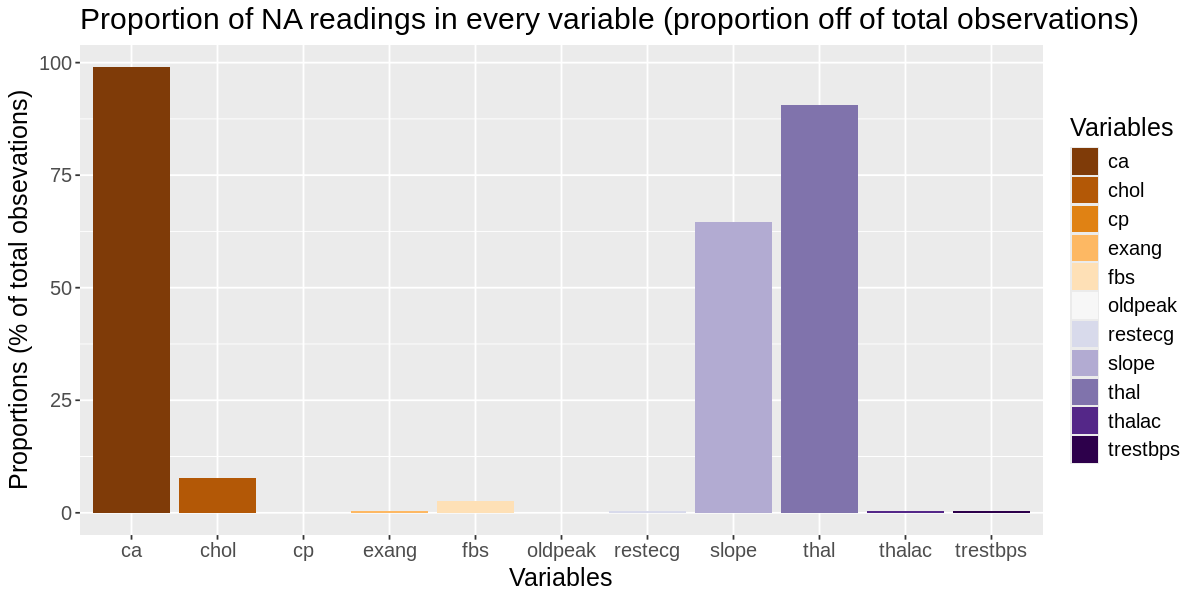

In [4]:
options(repr.plot.width = 10, repr.plot.height=5)

data_na_df <- hungarian_data |>
              select(cp:thal) |>
              map_df(~sum(is.na(.))) |>
              mutate(across(everything(), ~.x * (100/n_obs)))

data_na_df_vis <- pivot_longer(data_na_df,
                              cp:thal,
                              names_to = "Variables",
                              values_to = "Proportions") |>
                              ggplot(aes(x = Variables, y = Proportions, fill = Variables)) +
                              geom_bar(stat = "identity") +
                              scale_fill_brewer(palette = "PuOr") +
                              ggtitle("Proportion of NA readings in every variable (proportion off of total observations)") +
                              labs(x = "Variables",
                                  y = "Proportions (% of total obsevations)",
                                  fill = "Variables") +
                              theme(text = element_text(size = 15))
data_na_df
data_na_df_vis

## Splitting the data into testing and training set

In [5]:
hungarian_data_new <- hungarian_data |>
                  select(age,sex,trestbps,chol,thalac,oldpeak,num)

# hungarian_data_new is the modified and cleaned dataset, 
# it is the cleanest version of our dataset which will now 
# be split into training and testing for the purpose of analysis.

hungarian_data_split <- hungarian_data_new |>
                        initial_split(prop = 0.75, strata = num)
hungarian_data_train <- training(hungarian_data_split)
hungarian_data_test <- testing(hungarian_data_split)

hungarian_data_new
hungarian_data_train
hungarian_data_test

age,sex,trestbps,chol,thalac,oldpeak,num
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
28,Male,130,132,185,0,Negative
29,Male,120,243,160,0,Negative
29,Male,140,NA,170,0,Negative
⋮,⋮,⋮,⋮,⋮,⋮,⋮
56,Male,155,342,150,3,Positive
58,Female,180,393,110,1,Positive
65,Male,130,275,115,1,Positive


age,sex,trestbps,chol,thalac,oldpeak,num
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
28,Male,130,132,185,0,Negative
29,Male,120,243,160,0,Negative
29,Male,140,NA,170,0,Negative
⋮,⋮,⋮,⋮,⋮,⋮,⋮
56,Male,155,342,150,3,Positive
58,Female,180,393,110,1,Positive
65,Male,130,275,115,1,Positive


age,sex,trestbps,chol,thalac,oldpeak,num
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
35,Female,140,167,150,0,Negative
36,Male,150,160,172,0,Negative
37,Female,130,211,142,0,Negative
⋮,⋮,⋮,⋮,⋮,⋮,⋮
66,Male,140,NA,94,1.0,Positive
44,Male,135,491,135,0.0,Positive
50,Male,140,341,125,2.5,Positive


## Elementary level exploratory analysis on current variables

#### Table 1. Average value across all predictor variables based on sex and diagnosis

In [6]:
hungarian_train_mean <- hungarian_data_train |>
                        group_by(sex, num) |>
                        summarize(age_mean = mean(age, na.rm = TRUE),
                                  trestbps_mean = mean(trestbps, na.rm = TRUE),
                                  chol_mean = mean(chol, na.rm = TRUE),
                                  thalac_mean = mean(thalac, na.rm = TRUE),
                                  oldpeak_mean = mean(oldpeak, na.rm = TRUE))
hungarian_train_mean

`summarise()` has grouped output by 'sex'. You can override using the `.groups`
argument.


sex,num,age_mean,trestbps_mean,chol_mean,thalac_mean,oldpeak_mean
<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Female,Negative,47.11321,127.2308,239.5625,146.9615,0.3075472
Female,Positive,48.71429,135.7143,308.0000,122.5714,1.0714286
Male,Negative,45.84091,130.3750,239.6125,146.9205,0.1704545
Male,Positive,49.36111,134.4167,264.2059,127.7778,1.3750000


#### Table 2. Maximum value across all predictor variables based on sex and diagnosis

In [7]:
hungarian_train_max <- hungarian_data_train |>
                        group_by(sex, num) |>
                        summarize(age_max = max(age, na.rm = TRUE),
                                  trestbps_max = max(trestbps, na.rm = TRUE),
                                  chol_max = max(chol, na.rm = TRUE),
                                  thalac_max = max(thalac, na.rm = TRUE),
                                  oldpeak_max = max(oldpeak, na.rm = TRUE))
hungarian_train_max

`summarise()` has grouped output by 'sex'. You can override using the `.groups`
argument.


sex,num,age_max,trestbps_max,chol_max,thalac_max,oldpeak_max
<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Female,Negative,62,180,394,190,2
Female,Positive,59,180,393,150,2
Male,Negative,62,190,365,185,3
Male,Positive,65,180,603,175,5


#### Table 3. Minimum value accross all predictor variables based on sex and diagnosis

In [8]:
hungarian_train_min <- hungarian_data_train |>
                        group_by(sex, num) |>
                        summarize(age_min = min(age, na.rm = TRUE),
                                  trestbps_min = min(trestbps, na.rm = TRUE),
                                  chol_min = min(chol, na.rm = TRUE),
                                  thalac_min = min(thalac, na.rm = TRUE),
                                  oldpeak_min = min(oldpeak, na.rm = TRUE))
hungarian_train_min

`summarise()` has grouped output by 'sex'. You can override using the `.groups`
argument.


sex,num,age_min,trestbps_min,chol_min,thalac_min,oldpeak_min
<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Female,Negative,30,100,160,90,0
Female,Positive,33,100,205,98,0
Male,Negative,28,98,85,98,0
Male,Positive,31,92,117,82,0


#### Table 4. Finding the number of Female and Male entries in the dataset

In [9]:
#number of observations
n_obs_train <- nrow(hungarian_data_train)

hungarian_data_gender_proportion_train <- hungarian_data_train |>
                                    group_by(sex) |>
                                    summarize(total_number = n(),
                                              percentage = n()/n_obs_train * 100)

n_obs_train
hungarian_data_gender_proportion_train

[1] 220

sex,total_number,percentage
<chr>,<int>,<dbl>
Female,60,27.27273
Male,160,72.72727


### Distribution of age (in years) with respect to each diagnosis

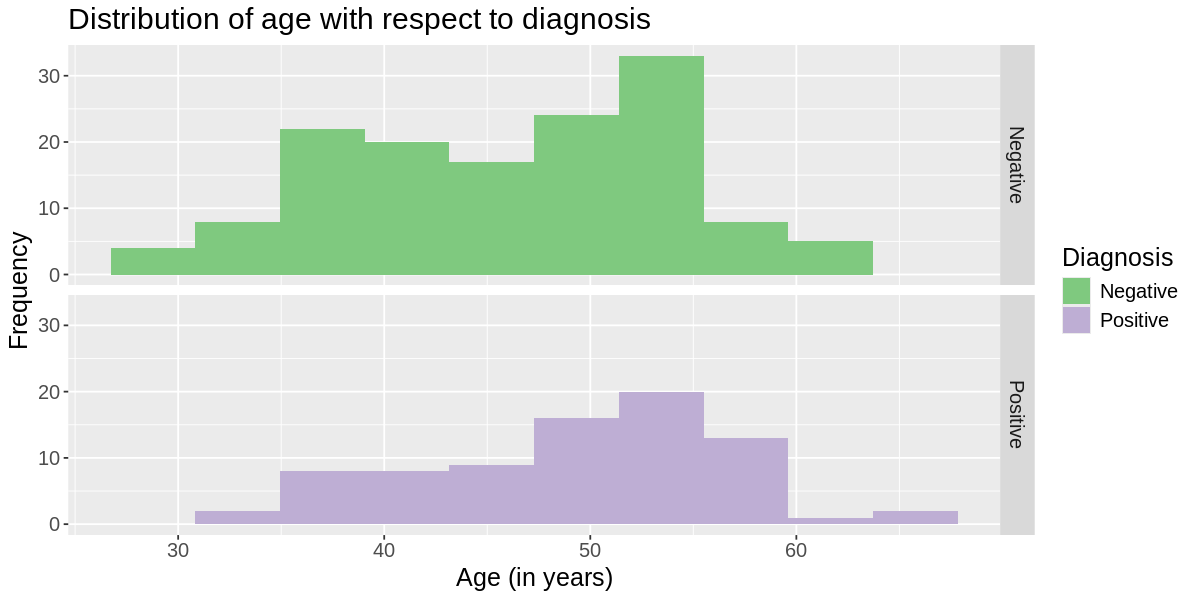

In [10]:
visualization_age <- hungarian_data_train |>
                     ggplot(aes(x = age, fill = num)) +
                     geom_histogram(bins = 10) +
                     labs(x = "Age (in years)", y = "Frequency", fill = "Diagnosis") +
                     facet_grid(rows = vars(num)) +
                     theme(text = element_text(size = 15)) +
                     ggtitle("Distribution of age with respect to diagnosis") + 
                     scale_fill_brewer(palette = "Accent")
visualization_age

### Distribution of diagnoses, with respect to each sex

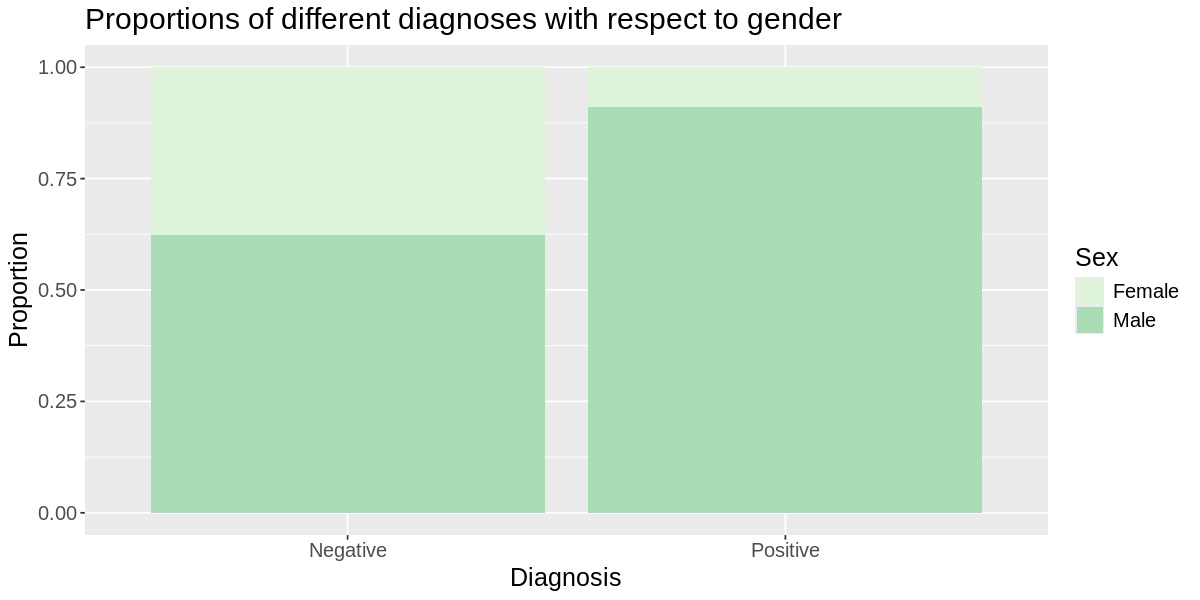

In [12]:
visualize_1 <- hungarian_data_train |>
               ggplot(aes(x = num, fill = sex)) +
               geom_bar(position = "fill") +
               labs(x = "Diagnosis", y = "Proportion", fill = "Sex") +
               scale_fill_brewer(palette = "GnBu") + 
               ggtitle("Proportions of different diagnoses with respect to gender") + 
               theme(text = element_text(size = 15))
visualize_1

### Distribution of Resting Blood Pressure on Admission (in mm) with respect to different diagnoses

Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_bin()`).”


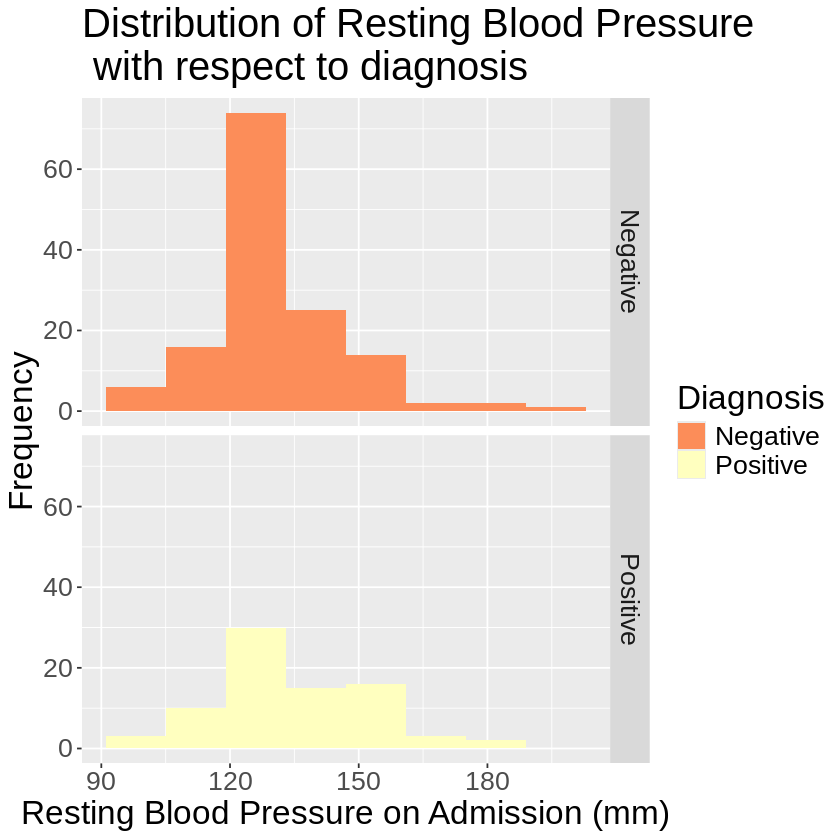

In [13]:
options(repr.plot.width = 7, repr.plot.height = 7)
hist_visualiz_trestbps <- hungarian_data_train |>
                 arrange(desc(age))  |>
                 ggplot(aes(x = trestbps, fill = num)) +
                 geom_histogram(bins = 8) +
                 facet_grid(rows = vars(num)) +
                 labs(x = "Resting Blood Pressure on Admission (mm)", y = "Frequency", fill = "Diagnosis") +
                 ggtitle("Distribution of Resting Blood Pressure \n with respect to diagnosis") + 
                 scale_fill_brewer(palette = "RdYlGn") + 
                 theme(text = element_text(size = 20))
                 
hist_visualiz_trestbps

### Distribution of Serum Cholesterol levels (in mg/dl) with respect to different diagnoses

Warning message:
“Removed 17 rows containing non-finite outside the scale range (`stat_bin()`).”


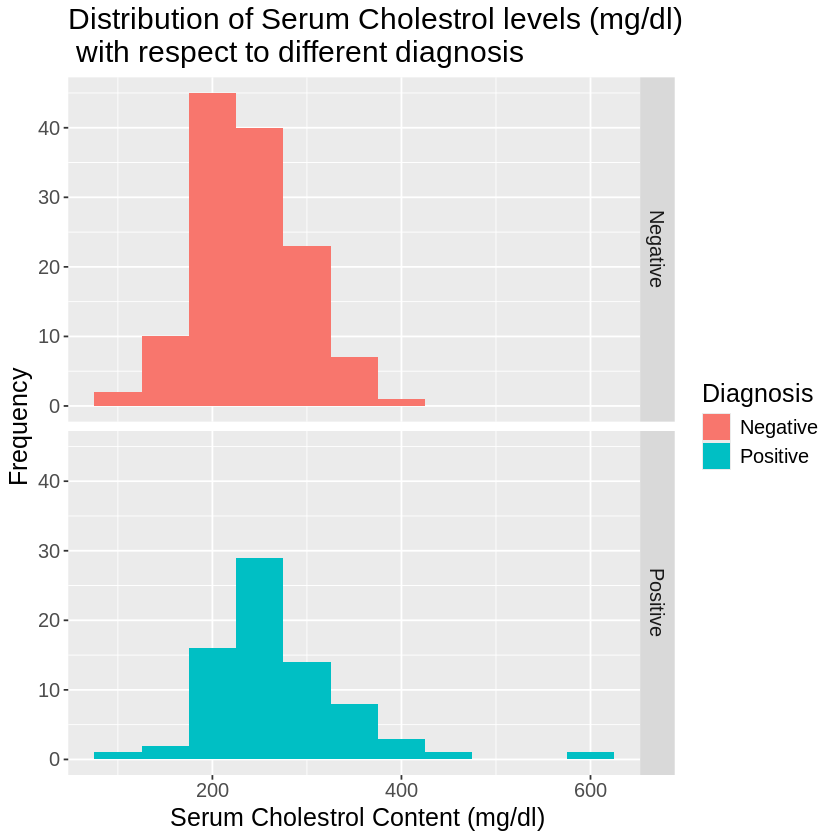

In [14]:
options(repr.plot.width = 7, repr.plot.height = 7)
hist_visualiz_chol <- hungarian_data_train |>
                 arrange(desc(age))  |>
                 ggplot(aes(x = chol, fill = num)) +
                 geom_histogram(binwidth = 50) +
                 facet_grid(rows = vars(num)) +
                 labs(x = " Serum Cholestrol Content (mg/dl)", y = "Frequency", fill = "Diagnosis") + 
                 ggtitle("Distribution of Serum Cholestrol levels (mg/dl)\n with respect to different diagnosis") + 
                 theme(text = element_text(size = 15))
                 
hist_visualiz_chol

### Distribution of Maximum heart rate achieved (in bmp) during monitoring period, with respect to different diagnoses

Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_bin()`).”


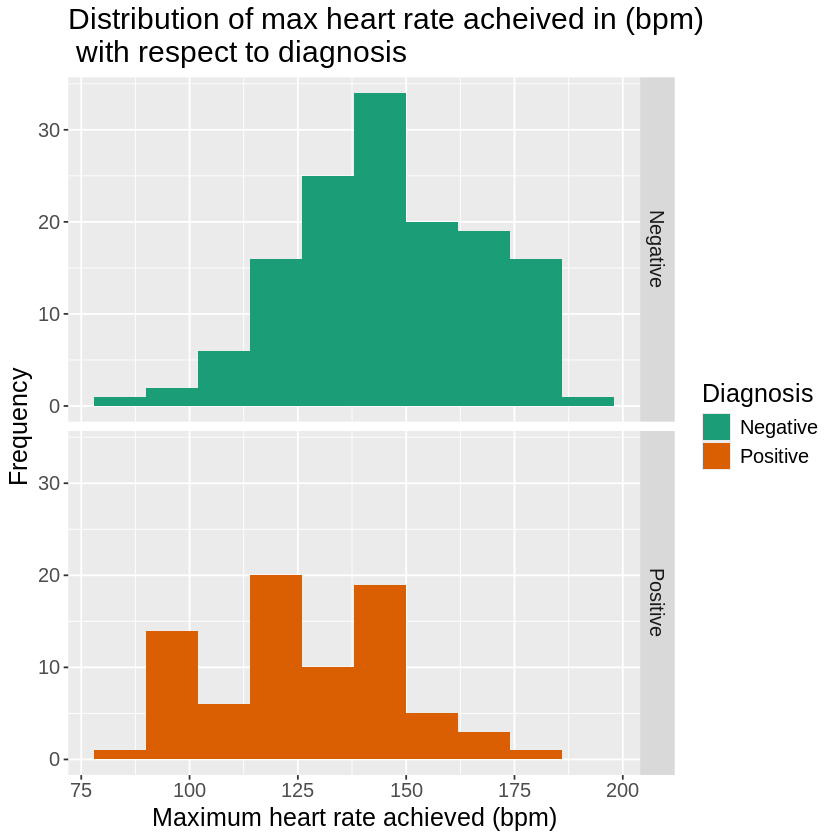

In [15]:
hist_visualize_thalac <- hungarian_data_train |>
                         ggplot(aes(x = thalac, fill = num)) +
                         geom_histogram(bins = 10) +
                         scale_fill_brewer(palette = "Dark2") +
                         labs(x = "Maximum heart rate achieved (bpm)", fill = "Diagnosis", y = "Frequency") +
                         ggtitle("Distribution of max heart rate acheived in (bpm)\n with respect to diagnosis") +
                         facet_grid(rows = vars(num)) +
                         theme(text = element_text(size = 15))

hist_visualize_thalac

### Distribution of oldpeak values for different diagnoses

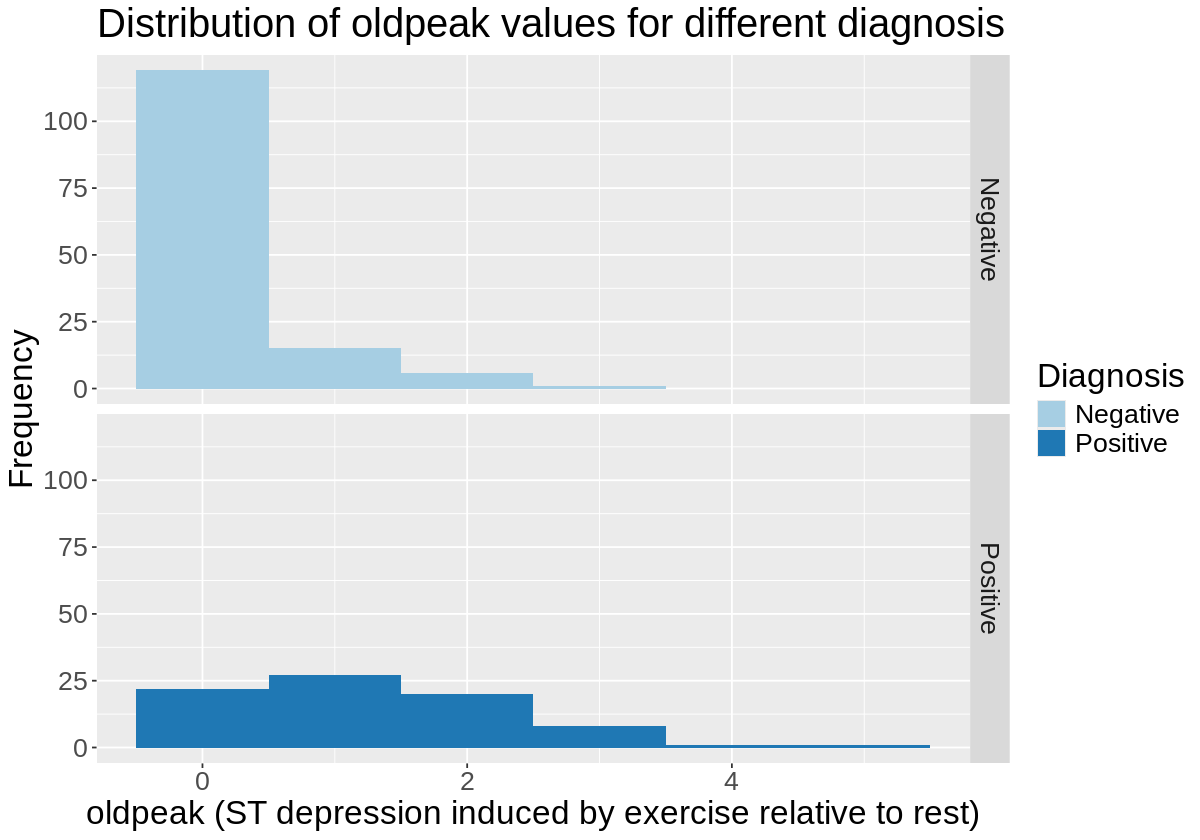

In [16]:
options(repr.plot.width = 10)
oldpeak_vis <- hungarian_data_train |>
               ggplot(aes(x = oldpeak, fill = num)) +
               geom_histogram(bins = 6) +
               facet_grid(rows = vars(num)) +
               labs(x = "oldpeak (ST depression induced by exercise relative to rest)",
                   y = "Frequency",
                   fill = "Diagnosis") +
               scale_fill_brewer(palette = "Paired") +
               ggtitle("Distribution of oldpeak values for different diagnosis") +
               theme(text = element_text(size = 20))
oldpeak_vis

## Training the KNN model to work with female training data, and evaluating performance for different K values

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.8182984,5,0.02691803,Preprocessor1_Model01


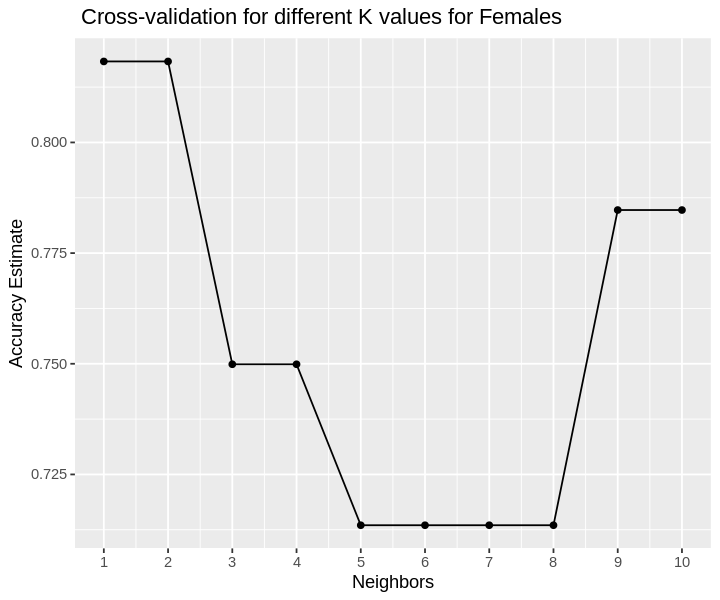

In [17]:
set.seed(127)
library(kknn)

options(repr.plot.height = 5, repr.plot.width = 6)

train_female <- hungarian_data_train |>
filter (sex == "Female")


recipe_female <- recipe(num ~ age + trestbps + chol+ thalac + oldpeak , data = train_female)|>
step_scale(all_predictors())|>
step_center(all_predictors()) |>
step_upsample(num, over_ratio = 1, skip = TRUE) |>
step_impute_mean(all_predictors()) 


vfold_female <- vfold_cv(train_female, v = 5, strata = num)

model <- nearest_neighbor (weight_func ="rectangular", neighbors = tune())|>
                                set_engine ("kknn")|>
                                set_mode ("classification")

values <- tibble(neighbors = seq(from= 1, to = 10 , by = 1))

knn_female <- workflow() |>
     add_recipe(recipe_female) |>
     add_model(model) |>
     tune_grid(resamples = vfold_female, grid = values) |>
     collect_metrics()

accuracy_female<- knn_female |> 
      filter(.metric == "accuracy")


cross_val_females <- ggplot(accuracy_female, aes(x = neighbors, y = mean))+
           geom_point() +
           geom_line() +
           labs(x = "Neighbors", y = "Accuracy Estimate") + 
            ggtitle (" Cross-validation for different K values for Females")+
scale_x_continuous(breaks = 1:10)

accuracy_female_max <- accuracy_female |>
                       arrange(desc(mean)) |>
                       slice(1)

accuracy_female_max
cross_val_females

# Summary
 As we can see the maximum accuracy obtained after cross folds validation is from a classifier that uses K = 3 for females

## Training the KNN model to work with male training data, and evaluating performance for different K values

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
9,accuracy,binary,0.7621395,5,0.04439942,Preprocessor1_Model09


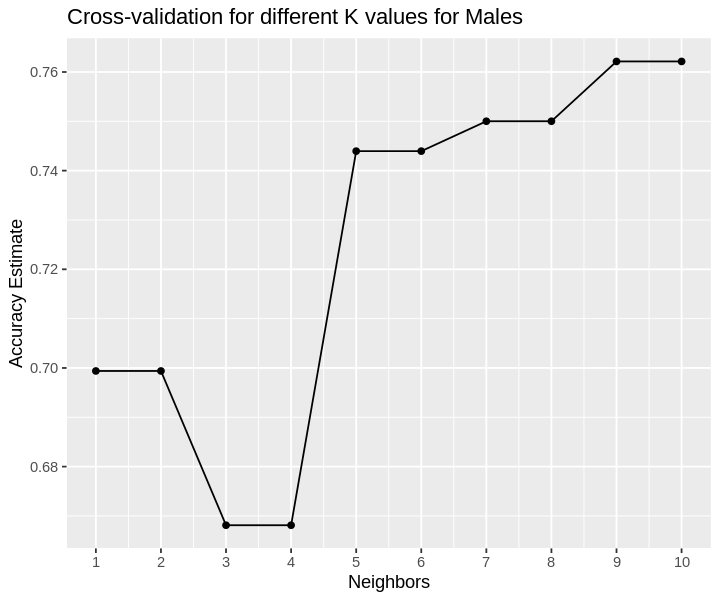

In [18]:

train_male <- hungarian_data_train |>
filter ( sex == "Male")


recipe_male <- recipe(num ~ age + trestbps + chol+ thalac + oldpeak , data = train_male)|>
step_scale(all_predictors())|>
step_center(all_predictors()) |>
step_upsample(num, over_ratio = 1, skip = TRUE) |>
step_impute_mean(all_predictors())

vfold_male <- vfold_cv(train_male, v = 5, strata = num)
model <- nearest_neighbor (weight_func ="rectangular", neighbors = tune())|>
                                set_engine ("kknn")|>
                                set_mode ("classification")

knn_male <- workflow() |>
     add_recipe(recipe_male) |>
     add_model(model) |>
     tune_grid(resamples = vfold_male, grid = values) |>
     collect_metrics()

accuracy_male<- knn_male |> 
      filter(.metric == "accuracy")


cross_val_males <- ggplot(accuracy_male, aes(x = neighbors, y = mean))+
           geom_point() +
           geom_line() +
           labs(x = "Neighbors", y = "Accuracy Estimate") + 
            ggtitle ("Cross-validation for different K values for Males")+ 
            scale_x_continuous(breaks = 1:10)

accuracy_male_max <- accuracy_male |>
                    arrange(desc(mean)) |>
                    slice(1)


accuracy_male_max
cross_val_males

# Summary
As we can see that maximum accuracy is obtained with K = 7 neighbors when working with the male data.

In [19]:
## Before working to predict the test data, we first split the test data into male and female test 
female_test <- hungarian_data_test |>
               filter(sex == "Female")
male_test <- hungarian_data_test |>
             filter(sex == "Male")

female_test
male_test

age,sex,trestbps,chol,thalac,oldpeak,num
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
35,Female,140,167,150,0,Negative
37,Female,130,211,142,0,Negative
41,Female,130,245,150,0,Negative
⋮,⋮,⋮,⋮,⋮,⋮,⋮
47,Female,135,248,170,0.0,Positive
48,Female,138,214,108,1.5,Positive
56,Female,120,279,150,1.0,Positive


age,sex,trestbps,chol,thalac,oldpeak,num
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
36,Male,150,160,172,0,Negative
37,Male,130,194,150,0,Negative
39,Male,130,NA,120,0,Negative
⋮,⋮,⋮,⋮,⋮,⋮,⋮
66,Male,140,NA,94,1.0,Positive
44,Male,135,491,135,0.0,Positive
50,Male,140,341,125,2.5,Positive


## Using Female Classifier on Testing Data and Performance Evaluation

In [20]:
## first create the classifier with the best number of K values for females
knn_female_max_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
                       set_engine("kknn") |>
                       set_mode("classification")

# now we will use the original recipe for female data and make our workflow for this spec
knn_final_female_fit <- workflow() |>
                             add_recipe(recipe_female) |>
                             add_model(knn_female_max_spec) |>
                             fit(train_female)


# now we use this workflow to predict the test set, but first we split the test set into male and female
female_prediction <- predict(knn_final_female_fit, female_test) |>
                     bind_cols(female_test)

female_prediction

female_prediction_accuracy <- female_prediction |>
                              metrics(truth = num, estimate = .pred_class) |>
                              filter(.metric == "accuracy")

female_prediction_accuracy 

# this tells us that the first level is a negative diagnosis and positive is the second level 
female_prediction |> pull(num) |> levels()

# female_prediction_precision
female_prediction |> precision(truth = num, estimate = .pred_class, event_level = "second")
female_prediction |> recall(truth = num, estimate = .pred_class, event_level = "second")
female_prediction |> conf_mat(truth = num, estimate = .pred_class)

.pred_class,age,sex,trestbps,chol,thalac,oldpeak,num
<fct>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
Negative,35,Female,140,167,150,0,Negative
Negative,37,Female,130,211,142,0,Negative
Negative,41,Female,130,245,150,0,Negative
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Negative,47,Female,135,248,170,0.0,Positive
Positive,48,Female,138,214,108,1.5,Positive
Negative,56,Female,120,279,150,1.0,Positive


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8571429


[1] "Negative" "Positive"

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,1


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.4


          Truth
Prediction Negative Positive
  Negative       16        3
  Positive        0        2

## Using Male Classifier on Testing Data and Performance Evaluation

In [21]:
## first create the classifier with the best number of K values for females
knn_male_max_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 7) |>
                       set_engine("kknn") |>
                       set_mode("classification")

# now we will use the original recipe for female data and make our workflow for this spec
knn_final_male_fit <- workflow() |>
                             add_recipe(recipe_male) |>
                             add_model(knn_male_max_spec) |>
                             fit(train_male)


# now we use this workflow to predict the test set, but first we split the test set into male and female
male_prediction <- predict(knn_final_male_fit, male_test) |>
                     bind_cols(male_test)

male_prediction

male_prediction_accuracy <- male_prediction |>
                              metrics(truth = num, estimate = .pred_class) |>
                              filter(.metric == "accuracy")

male_prediction_accuracy 

# this tells us that the first level is a negative diagnosis and positive is the second level 
male_prediction |> pull(num) |> levels()

# female_prediction_precision
male_prediction |> precision(truth = num, estimate = .pred_class, event_level = "second")
male_prediction |> recall(truth = num, estimate = .pred_class, event_level = "second")
male_prediction |> conf_mat(truth = num, estimate = .pred_class)

.pred_class,age,sex,trestbps,chol,thalac,oldpeak,num
<fct>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
Negative,36,Male,150,160,172,0,Negative
Negative,37,Male,130,194,150,0,Negative
Negative,39,Male,130,NA,120,0,Negative
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Positive,66,Male,140,NA,94,1.0,Positive
Positive,44,Male,135,491,135,0.0,Positive
Positive,50,Male,140,341,125,2.5,Positive


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7169811


[1] "Negative" "Positive"

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.64


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.7272727


          Truth
Prediction Negative Positive
  Negative       22        6
  Positive        9       16